In [259]:
import pandas as pd
import numpy as np
import pickle
import random
from sklearn import cluster
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt
from numpy import mean
from functools import reduce
from sklearn.cluster import KMeans

In [260]:
def oneHotEncoding(df, old_field):
    distinct_vals = list(set(reduce(lambda x,y:x+y,df[old_field])))
    cnt = len(distinct_vals)
    new_fields = [old_field+'_'+str(i) for i in range(cnt)]
    for i in range(cnt):
        df[new_fields[i]] = 0
        df[new_fields[i]] = df[old_field].map(lambda x: int(distinct_vals[i] in x))
    del df[old_field]
    return 1

In [261]:
def normalization(df,var,method='min-max'):
    '''
    :param df,var: the dataframe and column that need to be normalized. Please make sure it is not a constant, and also not empty
    :param method: normalization method
    :return: the normalized result or -1 for error input
    '''
    x = df[var]
    new_field = var + "_norm"
    if method == 'min-max':
        x_min = min(x)
        x_max = max(x)
        d = x_max - x_min
        df[new_field] = [(i-x_min)*1.0/d for i in x]
        del df[var]
        return 1
    elif method == 'zero-score':
        mu = np.mean(x)
        std = np.std(x)
        df[new_field] = [(i - mu) * 1.0 / std for i in x]
        del df[var]
        return 1
    else:
        print("Please specify the normalization method: min-max or zero-score")
        return -1

In [262]:
def makeupMissing(x, replaceVal):
    if np.isnan(x):
        return replaceVal
    else:
        return x

In [263]:
def minkovDist(x,y,p=2):
    '''
    :param x,y: the numpy arrays of two samples
    :param p: the degree of distance
    :return: the distance, or -1 if p is less than 1
    '''
    if p>=1:
        return (sum((x-y)**p)*1.0)**(1.0/p)
    else:
        print("p must be larger than or equal to 0")
        return -1

In [264]:
def KmeansAlgo(dataset, k):
    '''
    :param dataset: the dataset of clustering
    :param k: the number of clusters
    :return: the group label of each sample, the centroids and the cost
    '''
    N = dataset.shape[0]
    label = [0]*N
    # randomly select k samples as the initial centroids
    centroidsIndex = random.sample(range(N),k)
    centroids = [dataset[i,] for i in centroidsIndex]
    centroidsChanged = True
    while(centroidsChanged):
        centroidsChanged = False
        #Calculate the Minkovski distance between each point and the centriods
        #Assign the point to the group with min distance to the centroid of the group
        for i in range(N):
            dist_to_cent = [minkovDist(dataset[i,].getA()[0], centroid.getA()[0]) for centroid in centroids]
            label[i] = dist_to_cent.index(min(dist_to_cent))
        #Update the centroids using geometric centroid in the group
        for j in range(k):
            position = [p for p in range(N) if label[p] == j]
            clusterGroup = dataset[position]
            newCents = np.mean(clusterGroup, axis=0)
            #Judge whether the centrod is updated
            if minkovDist(newCents.getA()[0], centroids[j].getA()[0]) > 0.00001:
                centroidsChanged = True
                centroids[j] = newCents
            else:
                centroidsChanged = False
    #calculate the cost function
    cost = 0
    for i in range(N):
        centroid = centroids[label[i]]
        dist_to_cent = minkovDist(dataset[i,].getA()[0], centroid.getA()[0])
        cost += dist_to_cent**2
    cost = cost/N
    return {'group':label, 'centroids':centroids, 'cost':cost}

#  数据预处理

In [265]:
loan_table = pd.read_csv("input/loan_details.csv", encoding="gb2312")[:1000]
loan_table.head()

,CUST_ID,Loan_Type,Loan_Term,Start_Date,End_Date,Loan_Amt,Undisbursed_Amt,Business_Type_Code,Business_Type_Name,Credit_Ind,...,Marriage_Interpret,Edu_Level,Monthky_Income,Job,Industry,Rural,External_Ind,Credit_Level,Gender,Age
0,K1120900035525,1,240,20090113,20290113,150000,106648.23,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,城,内,3.0,男,43.0
1,K1120900039759,5,240,20090119,20290119,500000,NaN,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,城,内,2.0,女,53.0
2,K1120900042574,1,240,20090211,20290211,540000,385902.43,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,城,内,3.0,女,38.0
3,K1120900041117,1,180,20090212,20240212,200000,112736.63,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,城,内,5.0,女,51.0
4,K1120900037988,1,120,20090212,20190212,147000,34415.31,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,城,内,3.0,男,38.0


In [266]:
loan_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
CUST_ID               1000 non-null object
Loan_Type             1000 non-null int64
Loan_Term             1000 non-null int64
Start_Date            1000 non-null int64
End_Date              1000 non-null int64
Loan_Amt              1000 non-null int64
Undisbursed_Amt       995 non-null float64
Business_Type_Code    1000 non-null int64
Business_Type_Name    1000 non-null object
Credit_Ind            1000 non-null int64
Interest_Rate         1000 non-null float64
Repay_Way             1000 non-null int64
Pay_Way               1000 non-null float64
Interest_Payment      1000 non-null float64
Marriage              1000 non-null int64
Marriage_Interpret    1000 non-null object
Edu_Level             10 non-null object
Monthky_Income        7 non-null float64
Job                   10 non-null object
Industry              19 non-null object
Rural                 1000 non-null object
Exter

In [267]:
loan_table.describe()

,Loan_Type,Loan_Term,Start_Date,End_Date,Loan_Amt,Undisbursed_Amt,Business_Type_Code,Credit_Ind,Interest_Rate,Repay_Way,Pay_Way,Interest_Payment,Marriage,Monthky_Income,Credit_Level,Age
count,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1.000000e+03,995.000000,1000.0,1000.0,1000.000000,1000.00000,1000.0,1000.0,1000.000000,7.000000,983.000000,995.000000
mean,1.027000,165.984000,2.009063e+07,2.022895e+07,1.386729e+05,65277.601477,1.0,1.0,3.875239,196.20000,1.0,1.0,5.989000,82371.428571,2.890132,43.342714
std,0.313639,60.405567,9.738258e+01,5.033444e+04,1.040244e+05,64985.280553,0.0,0.0,0.560483,19.12919,0.0,0.0,0.284535,41123.298923,0.824852,8.525859
min,1.000000,96.000000,2.009011e+07,2.017061e+07,3.500000e+04,2500.060000,1.0,1.0,3.430000,100.00000,1.0,1.0,1.000000,33600.000000,1.000000,27.000000
25%,1.000000,120.000000,2.009061e+07,2.019062e+07,8.000000e+04,24530.600000,1.0,1.0,3.430000,200.00000,1.0,1.0,6.000000,51600.000000,2.000000,37.000000
50%,1.000000,120.000000,2.009063e+07,2.019072e+07,1.100000e+05,45528.580000,1.0,1.0,3.675000,200.00000,1.0,1.0,6.000000,85800.000000,3.000000,42.000000
75%,1.000000,180.000000,2.009071e+07,2.024072e+07,1.500000e+05,85366.050000,1.0,1.0,4.165000,200.00000,1.0,1.0,6.000000,100800.000000,3.000000,49.000000
max,5.000000,360.000000,2.009073e+07,2.039073e+07,1.160000e+06,880749.820000,1.0,1.0,7.072500,200.00000,1.0,1.0,7.000000,152400.000000,6.000000,65.000000


In [268]:
id_freq = loan_table.groupby(["CUST_ID"])["CUST_ID"].count()
id_freq[:5]

CUST_ID
K1120800001706    1
K1120800001895    1
K1120800002825    1
K1120800004680    1
K1120800008731    1
Name: CUST_ID, dtype: int64

In [269]:
id_freq_2 = id_freq.to_dict()
id_freq_3 = [k for k, v in id_freq_2.items() if v > 1]
id_freq_3[:5]

['K1120900096875',
 'K1120900104162',
 'K1120900109953',
 'K1120900100236',
 'K1120900101194']

In [270]:
id_freq_4 = pd.DataFrame({"CUST_ID": id_freq_3})
id_freq_4.head()

,CUST_ID
0,K1120900096875
1,K1120900104162
2,K1120900109953
3,K1120900100236
4,K1120900101194


一些值的重复是因为信息的更新，数据中'CUST_ID','Loan_Type','Loan_Term','Start_Date','End_Date','Loan_Amt','Undisbursed_Amt','Business_Type_Code'这些字段是相同的

In [271]:
dup_records = id_freq_4.merge(loan_table, on="CUST_ID", how="inner")[['CUST_ID', 'Loan_Type','Loan_Term','Start_Date','End_Date',
                                                                     'Loan_Amt','Undisbursed_Amt','Business_Type_Code']]
dup_records.head()

,CUST_ID,Loan_Type,Loan_Term,Start_Date,End_Date,Loan_Amt,Undisbursed_Amt,Business_Type_Code
0,K1120900096875,1,120,20090616,20190616,55000,14516.60,1
1,K1120900096875,1,120,20090616,20190616,55000,14516.60,1
2,K1120900104162,1,120,20090713,20190713,120000,33848.67,1
3,K1120900104162,1,120,20090721,20190721,80000,23756.24,1
4,K1120900109953,1,120,20090721,20190721,140000,41573.49,1


移除重复的记录

In [272]:
dup_records2 = dup_records.drop_duplicates()
dup_records2.head()

,CUST_ID,Loan_Type,Loan_Term,Start_Date,End_Date,Loan_Amt,Undisbursed_Amt,Business_Type_Code
0,K1120900096875,1,120,20090616,20190616,55000,14516.60,1
2,K1120900104162,1,120,20090713,20190713,120000,33848.67,1
3,K1120900104162,1,120,20090721,20190721,80000,23756.24,1
4,K1120900109953,1,120,20090721,20190721,140000,41573.49,1
5,K1120900109953,1,120,20090721,20190721,130000,38603.98,1


In [273]:
id_dup = dup_records2.groupby(["CUST_ID"])["CUST_ID"].count().to_dict()
id_dup_1 = [k for k, v in id_dup.items() if v == 1]
id_dup_1[:5]

['K1120900097739',
 'K1120900098413',
 'K1120900101194',
 'K1120900070551',
 'K1120900096875']

In [274]:
id_dup_1_df = pd.DataFrame({"CUST_ID": id_dup_1})
id_dup_1_df.head()

,CUST_ID
0,K1120900097739
1,K1120900098413
2,K1120900101194
3,K1120900070551
4,K1120900096875


In [275]:
drop_dup_1 = pd.merge(id_dup_1_df, loan_table, on="CUST_ID", how="left")
drop_dup_1.head()

,CUST_ID,Loan_Type,Loan_Term,Start_Date,End_Date,Loan_Amt,Undisbursed_Amt,Business_Type_Code,Business_Type_Name,Credit_Ind,...,Marriage_Interpret,Edu_Level,Monthky_Income,Job,Industry,Rural,External_Ind,Credit_Level,Gender,Age
0,K1120900097739,1,348,20090622,20380622,130000,111683.53,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,2.0,女,32.0
1,K1120900097739,1,348,20090622,20380622,130000,111683.53,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,2.0,女,32.0
2,K1120900098413,1,120,20090621,20190621,180000,47508.75,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,3.0,男,57.0
3,K1120900098413,1,120,20090621,20190621,180000,47508.75,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,3.0,男,57.0
4,K1120900101194,1,120,20090625,20190625,127000,33520.06,1,个人二手住房贷款,1,...,已婚,高中,NaN,商业、服务业人员,NaN,乡,内,4.0,女,43.0


In [276]:
drop_dup_1b = drop_dup_1.groupby(["CUST_ID"]).last()
drop_dup_1b.head()

,Loan_Type,Loan_Term,Start_Date,End_Date,Loan_Amt,Undisbursed_Amt,Business_Type_Code,Business_Type_Name,Credit_Ind,Interest_Rate,...,Marriage_Interpret,Edu_Level,Monthky_Income,Job,Industry,Rural,External_Ind,Credit_Level,Gender,Age
CUST_ID,,,,,,,,,,,,,,,,,,,,,
K1120900070551,1,120,20090430,20190430,200000,49044.95,1,个人二手住房贷款,1,3.430,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,2.0,女,54.0
K1120900096875,1,120,20090616,20190616,55000,14516.60,1,个人二手住房贷款,1,3.430,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,3.0,男,39.0
K1120900097739,1,348,20090622,20380622,130000,111683.53,1,个人二手住房贷款,1,4.165,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,2.0,女,32.0
K1120900098413,1,120,20090621,20190621,180000,47508.75,1,个人二手住房贷款,1,3.430,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,3.0,男,57.0
K1120900101194,1,120,20090625,20190625,127000,33520.06,1,个人二手住房贷款,1,3.430,...,未说明的婚姻状况,高中,NaN,商业、服务业人员,NaN,乡,内,4.0,女,43.0


In [277]:
id_all = list(id_freq.index)
id_non_dup = [i for i in id_all if i not in drop_dup_1b.index]
id_non_dup[:5]

['K1120800001706',
 'K1120800001895',
 'K1120800002825',
 'K1120800004680',
 'K1120800008731']

In [278]:
id_non_dup_df = pd.DataFrame({"CUST_ID": id_non_dup})
id_non_dup_df_2 = pd.merge(id_non_dup_df, loan_table, on="CUST_ID", how="left")
id_non_dup_df_2.head()

,CUST_ID,Loan_Type,Loan_Term,Start_Date,End_Date,Loan_Amt,Undisbursed_Amt,Business_Type_Code,Business_Type_Name,Credit_Ind,...,Marriage_Interpret,Edu_Level,Monthky_Income,Job,Industry,Rural,External_Ind,Credit_Level,Gender,Age
0,K1120800001706,1,180,20090713,20240713,100000,58585.44,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,2.0,女,40.0
1,K1120800001895,1,360,20090402,20390402,182000,102698.06,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,4.0,女,38.0
2,K1120800002825,1,120,20090626,20190626,150000,33750.00,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,3.0,男,62.0
3,K1120800004680,1,120,20090601,20190601,156000,42519.69,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,4.0,男,44.0
4,K1120800008731,1,120,20090723,20190723,46000,12839.56,1,个人二手住房贷款,1,...,未说明的婚姻状况,NaN,NaN,NaN,NaN,乡,内,3.0,男,38.0


In [279]:
id_loans = pd.concat([id_non_dup_df_2, drop_dup_1b])
id_loans.head()

,Age,Business_Type_Code,Business_Type_Name,CUST_ID,Credit_Ind,Credit_Level,Edu_Level,End_Date,External_Ind,Gender,...,Loan_Term,Loan_Type,Marriage,Marriage_Interpret,Monthky_Income,Pay_Way,Repay_Way,Rural,Start_Date,Undisbursed_Amt
0,40.0,1,个人二手住房贷款,K1120800001706,1,2.0,NaN,20240713,内,女,...,180,1,6,未说明的婚姻状况,NaN,1.0,200,乡,20090713,58585.44
1,38.0,1,个人二手住房贷款,K1120800001895,1,4.0,NaN,20390402,内,女,...,360,1,6,未说明的婚姻状况,NaN,1.0,100,乡,20090402,102698.06
2,62.0,1,个人二手住房贷款,K1120800002825,1,3.0,NaN,20190626,内,男,...,120,1,6,未说明的婚姻状况,NaN,1.0,100,乡,20090626,33750.00
3,44.0,1,个人二手住房贷款,K1120800004680,1,4.0,NaN,20190601,内,男,...,120,1,6,未说明的婚姻状况,NaN,1.0,200,乡,20090601,42519.69
4,38.0,1,个人二手住房贷款,K1120800008731,1,3.0,NaN,20190723,内,男,...,120,1,6,未说明的婚姻状况,NaN,1.0,200,乡,20090723,12839.56


# 填补空缺值

In [280]:
id_loans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0 to K1120900101194
Data columns (total 25 columns):
Age                   990 non-null float64
Business_Type_Code    995 non-null int64
Business_Type_Name    995 non-null object
CUST_ID               990 non-null object
Credit_Ind            995 non-null int64
Credit_Level          978 non-null float64
Edu_Level             10 non-null object
End_Date              995 non-null int64
External_Ind          995 non-null object
Gender                995 non-null object
Industry              19 non-null object
Interest_Payment      995 non-null float64
Interest_Rate         995 non-null float64
Job                   10 non-null object
Loan_Amt              995 non-null int64
Loan_Term             995 non-null int64
Loan_Type             995 non-null int64
Marriage              995 non-null int64
Marriage_Interpret    995 non-null object
Monthky_Income        7 non-null float64
Pay_Way               995 non-null float64
Repay_Way    

In [281]:
temp = id_loans.apply(lambda x: int(makeupMissing(x.Credit_Level, 0)), axis=1)
id_loans["Credit_Level"] = temp
id_loans[id_loans["Credit_Level"] == 0].head() 

,Age,Business_Type_Code,Business_Type_Name,CUST_ID,Credit_Ind,Credit_Level,Edu_Level,End_Date,External_Ind,Gender,...,Loan_Term,Loan_Type,Marriage,Marriage_Interpret,Monthky_Income,Pay_Way,Repay_Way,Rural,Start_Date,Undisbursed_Amt
8,46.0,1,个人二手住房贷款,K1120800020739,1,0,NaN,20190713,内,男,...,120,1,6,未说明的婚姻状况,NaN,1.0,200,乡,20090713,50241.74
34,35.0,1,个人二手住房贷款,K1120900051588,1,0,NaN,20390616,内,男,...,360,1,6,未说明的婚姻状况,NaN,1.0,200,城,20090616,78173.69
59,44.0,1,个人二手住房贷款,K1120900065398,1,0,NaN,20190511,内,男,...,120,1,6,未说明的婚姻状况,NaN,1.0,200,乡,20090511,18410.84
230,43.0,1,个人二手住房贷款,K1120900092870,1,0,NaN,20290605,内,男,...,240,1,6,未说明的婚姻状况,NaN,1.0,200,乡,20090605,91862.14
249,41.0,1,个人二手住房贷款,K1120900094094,1,0,NaN,20290609,内,男,...,240,1,6,未说明的婚姻状况,NaN,1.0,200,乡,20090609,66733.67


对于有多条借贷信息的客户，我们使用list去捕获细节

In [282]:
all_vars = list(id_loans.columns)
all_vars.remove("CUST_ID")
all_vars

['Age',
 'Business_Type_Code',
 'Business_Type_Name',
 'Credit_Ind',
 'Credit_Level',
 'Edu_Level',
 'End_Date',
 'External_Ind',
 'Gender',
 'Industry',
 'Interest_Payment',
 'Interest_Rate',
 'Job',
 'Loan_Amt',
 'Loan_Term',
 'Loan_Type',
 'Marriage',
 'Marriage_Interpret',
 'Monthky_Income',
 'Pay_Way',
 'Repay_Way',
 'Rural',
 'Start_Date',
 'Undisbursed_Amt']

In [283]:
for var in all_vars:
    id_loans[var] = id_loans[var].apply(lambda x: [x])
id_loans_group = id_loans.groupby("CUST_ID").sum()

id_loans_group[:5]

,Age,Business_Type_Code,Business_Type_Name,Credit_Ind,Credit_Level,Edu_Level,End_Date,External_Ind,Gender,Industry,...,Loan_Term,Loan_Type,Marriage,Marriage_Interpret,Monthky_Income,Pay_Way,Repay_Way,Rural,Start_Date,Undisbursed_Amt
CUST_ID,,,,,,,,,,,,,,,,,,,,,
K1120800001706,[40.0],[1],[个人二手住房贷款],[1],[2],[nan],[20240713],[内],[女],[nan],...,[180],[1],[6],[未说明的婚姻状况],[nan],[1.0],[200],[乡],[20090713],[58585.44]
K1120800001895,[38.0],[1],[个人二手住房贷款],[1],[4],[nan],[20390402],[内],[女],[nan],...,[360],[1],[6],[未说明的婚姻状况],[nan],[1.0],[100],[乡],[20090402],[102698.06]
K1120800002825,[62.0],[1],[个人二手住房贷款],[1],[3],[nan],[20190626],[内],[男],[nan],...,[120],[1],[6],[未说明的婚姻状况],[nan],[1.0],[100],[乡],[20090626],[33750.0]
K1120800004680,[44.0],[1],[个人二手住房贷款],[1],[4],[nan],[20190601],[内],[男],[nan],...,[120],[1],[6],[未说明的婚姻状况],[nan],[1.0],[200],[乡],[20090601],[42519.69]
K1120800008731,[38.0],[1],[个人二手住房贷款],[1],[3],[nan],[20190723],[内],[男],[nan],...,[120],[1],[6],[未说明的婚姻状况],[nan],[1.0],[200],[乡],[20090723],[12839.56]


保存清洗完的数据

In [214]:
with open("output/id_loans_group.pkl", "wb") as f:
    pickle.dump(id_loans_group, f)

从pickle中读取数据

In [241]:
with open("output/id_loans_group.pickle", "rb") as f:
    id_loans_group = pickle.load(f)
id_loans_group.head()

,Age,Business_Type_Code,Business_Type_Name,Credit_Ind,Credit_Level,Edu_Level,End_Date,External_Ind,Gender,Industry,...,Loan_Term,Loan_Type,Marriage,Marriage_Interpret,Monthky_Income,Pay_Way,Repay_Way,Rural,Start_Date,Undisbursed_Amt
CUST_ID,,,,,,,,,,,,,,,,,,,,,
00006b34057d46bda631dee166686161,[59.0],[1],[个人二手住房贷款],[0],[3],[nan],[20221221],[内],[男],[数字内容服务],...,[84],[1],[6],[未说明的婚姻状况],[nan],[2.0],[200],[城],[20151221],[77235.15]
0000cf0923ce4af8a61783dffc9944bc,[31.0],[4],[个人一手住房贷款],[0],[5],[nan],[20440326],[内],[女],[nan],...,[360],[1],[6],[未说明的婚姻状况],[nan],[2.0],[200],[城],[20140326],[249221.72]
00027cc01a6749699afbdee00f5ba4a0,[48.0],[1],[个人二手住房贷款],[0],[3],[nan],[20330729],[内],[女],[其他未列明专业技术服务业],...,[204],[1],[6],[未说明的婚姻状况],[nan],[2.0],[200],[城],[20160729],[439723.59]
000404dec593450b94368544532bb579,"[53.0, 53.0, 53.0]","[5, 5, 5]","[个人综合消费贷款, 个人综合消费贷款, 个人综合消费贷款]","[0, 0, 0]","[4, 4, 4]","[大专, nan, nan]","[20190520, 20191009, 20220306]","[内, 内, 内]","[男, 男, 男]","[其他专业技术服务, 其他专业技术服务, 其他专业技术服务]",...,"[60, 60, 60]","[1, 1, 1]","[5, 6, 6]","[未婚, 未说明的婚姻状况, 未说明的婚姻状况]","[105600.0, nan, nan]","[1.0, 1.0, 1.0]","[200, 200, 200]","[乡, 乡, 乡]","[20140520, 20141009, 20170306]","[38225.33, 5603.52, 10000.0]"
0004ce24722c4db0afa32127cce51992,[30.0],[5],[个人综合消费贷款],[0],[5],[nan],[20231123],[内],[男],[nan],...,[120],[1],[6],[未说明的婚姻状况],[nan],[1.0],[200],[乡],[20131123],[171411.64]


# 数据预处理

## 借贷类型号

In [242]:
var1 = id_loans_group.apply(lambda x: len(set(x.Loan_Type)), axis=1)
var1 = var1.to_frame(name="No_Loan_Types")
var1.head()

,No_Loan_Types
CUST_ID,
00006b34057d46bda631dee166686161,1
0000cf0923ce4af8a61783dffc9944bc,1
00027cc01a6749699afbdee00f5ba4a0,1
000404dec593450b94368544532bb579,1
0004ce24722c4db0afa32127cce51992,1


## 借贷数 

In [243]:
var2 = id_loans_group.apply(lambda x: len(x.Loan_Type), axis=1)
var2 = var2.to_frame(name="No_Loan")
var2.head()

,No_Loan
CUST_ID,
00006b34057d46bda631dee166686161,1
0000cf0923ce4af8a61783dffc9944bc,1
00027cc01a6749699afbdee00f5ba4a0,1
000404dec593450b94368544532bb579,3
0004ce24722c4db0afa32127cce51992,1


## 最大借贷期数

In [244]:
var3a = id_loans_group.apply(lambda x: max(x.Loan_Term), axis=1)
var3a = var3a.to_frame(name="Max_Loan_Terms")
var3a.head()

,Max_Loan_Terms
CUST_ID,
00006b34057d46bda631dee166686161,84
0000cf0923ce4af8a61783dffc9944bc,360
00027cc01a6749699afbdee00f5ba4a0,204
000404dec593450b94368544532bb579,60
0004ce24722c4db0afa32127cce51992,120


## 最小借贷周期

In [245]:
var3b = id_loans_group.apply(lambda x: min(x.Loan_Term), axis=1)
var3b = var3b.to_frame(name="Min_Loan_Terms")
var3b.head()

,Min_Loan_Terms
CUST_ID,
00006b34057d46bda631dee166686161,84
0000cf0923ce4af8a61783dffc9944bc,360
00027cc01a6749699afbdee00f5ba4a0,204
000404dec593450b94368544532bb579,60
0004ce24722c4db0afa32127cce51992,120


## 平均借贷周期

In [246]:
var3c = id_loans_group.apply(lambda x: mean(x.Loan_Term), axis=1)
var3c = var3c.to_frame(name="Mean_Loan_Terms")
var3c.head()

,Mean_Loan_Terms
CUST_ID,
00006b34057d46bda631dee166686161,84.0
0000cf0923ce4af8a61783dffc9944bc,360.0
00027cc01a6749699afbdee00f5ba4a0,204.0
000404dec593450b94368544532bb579,60.0
0004ce24722c4db0afa32127cce51992,120.0


## 总借款金额

In [247]:
var4a = id_loans_group.apply(lambda x: sum(x.Loan_Amt), axis=1)
var4a = var4a.to_frame(name="Total_Loan_Amt")
var4a.head()

,Total_Loan_Amt
CUST_ID,
00006b34057d46bda631dee166686161,90000
0000cf0923ce4af8a61783dffc9944bc,260000
00027cc01a6749699afbdee00f5ba4a0,450000
000404dec593450b94368544532bb579,100000
0004ce24722c4db0afa32127cce51992,228000


## 平均贷款金额

In [248]:
var4b = id_loans_group.apply(lambda x: mean(x.Loan_Amt), axis=1)
var4b = var4b.to_frame(name="Mean_Loan_Amt")
var4b.head()

,Mean_Loan_Amt
CUST_ID,
00006b34057d46bda631dee166686161,90000.000000
0000cf0923ce4af8a61783dffc9944bc,260000.000000
00027cc01a6749699afbdee00f5ba4a0,450000.000000
000404dec593450b94368544532bb579,33333.333333
0004ce24722c4db0afa32127cce51992,228000.000000


## 总未还款额

In [249]:
var5a = id_loans_group.apply(lambda x: sum(x.Undisbursed_Amt),axis=1)
var5a = var5a.to_frame(name='Total_Undisbursed_Amt')
var5a.head()

,Total_Undisbursed_Amt
CUST_ID,
00006b34057d46bda631dee166686161,77235.15
0000cf0923ce4af8a61783dffc9944bc,249221.72
00027cc01a6749699afbdee00f5ba4a0,439723.59
000404dec593450b94368544532bb579,53828.85
0004ce24722c4db0afa32127cce51992,171411.64


## 平均未还款额

In [250]:
var5b = id_loans_group.apply(lambda x: mean(x.Undisbursed_Amt),axis=1)
var5b = var5b.to_frame(name='Mean_Undisbursed_Amt')
var5b.head()

,Mean_Undisbursed_Amt
CUST_ID,
00006b34057d46bda631dee166686161,77235.15
0000cf0923ce4af8a61783dffc9944bc,249221.72
00027cc01a6749699afbdee00f5ba4a0,439723.59
000404dec593450b94368544532bb579,17942.95
0004ce24722c4db0afa32127cce51992,171411.64


## 未还款总额与借贷总额的比率

In [251]:
var6a = pd.concat([var4a, var5a], axis=1)
var6a["Total_Undisbursed_to_Loan"] = var6a.apply(lambda x: x.Total_Undisbursed_Amt/x.Total_Loan_Amt, axis=1)
del var6a["Total_Undisbursed_Amt"]
del var6a["Total_Loan_Amt"]
var6a.head()

,Total_Undisbursed_to_Loan
CUST_ID,
00006b34057d46bda631dee166686161,0.858168
0000cf0923ce4af8a61783dffc9944bc,0.958545
00027cc01a6749699afbdee00f5ba4a0,0.977164
000404dec593450b94368544532bb579,0.538289
0004ce24722c4db0afa32127cce51992,0.751805


In [252]:
var6b = pd.concat([var4b, var5b], axis=1)
var6b["Mean_Undisbursed_to_Loan"] = var6b.apply(lambda x: x.Mean_Undisbursed_Amt/x.Mean_Loan_Amt, axis=1)
del var6b["Mean_Undisbursed_Amt"]
del var6b["Mean_Loan_Amt"]
var6b.head()

,Mean_Undisbursed_to_Loan
CUST_ID,
00006b34057d46bda631dee166686161,0.858168
0000cf0923ce4af8a61783dffc9944bc,0.958545
00027cc01a6749699afbdee00f5ba4a0,0.977164
000404dec593450b94368544532bb579,0.538288
0004ce24722c4db0afa32127cce51992,0.751805


## 归一化

In [253]:
normalization(var4a,'Total_Loan_Amt')
normalization(var4b,'Mean_Loan_Amt')
normalization(var5a,'Total_Undisbursed_Amt')
normalization(var5b,'Mean_Undisbursed_Amt')

1

## 每个客户的最小及最大利息率

In [254]:
var7a = id_loans_group.apply(lambda x: min(x.Interest_Rate), axis=1)
var7a = var7a.to_frame(name="Min_Interest_Rate")
normalization(var7a, "Min_Interest_Rate")
var7a.head()

,Min_Interest_Rate_norm
CUST_ID,
00006b34057d46bda631dee166686161,0.534097
0000cf0923ce4af8a61783dffc9944bc,0.534097
00027cc01a6749699afbdee00f5ba4a0,0.507365
000404dec593450b94368544532bb579,0.673213
0004ce24722c4db0afa32127cce51992,0.747954


In [255]:
var7b = id_loans_group.apply(lambda x: max(x.Interest_Rate), axis=1)
var7b = var7b.to_frame(name="Max_Interest_Rate")
normalization(var7b, "Max_Interest_Rate")
var7b.head()

,Max_Interest_Rate_norm
CUST_ID,
00006b34057d46bda631dee166686161,0.534097
0000cf0923ce4af8a61783dffc9944bc,0.534097
00027cc01a6749699afbdee00f5ba4a0,0.507365
000404dec593450b94368544532bb579,0.776869
0004ce24722c4db0afa32127cce51992,0.747954


In [256]:
derived_features = pd.concat([var1,var2,var3a,var3b,var3c,var4a,var4b,var5a,var5b,var6a,var6b,var7a,var7b], axis=1)
derived_features.head()

,No_Loan_Types,No_Loan,Max_Loan_Terms,Min_Loan_Terms,Mean_Loan_Terms,Total_Loan_Amt_norm,Mean_Loan_Amt_norm,Total_Undisbursed_Amt_norm,Mean_Undisbursed_Amt_norm,Total_Undisbursed_to_Loan,Mean_Undisbursed_to_Loan,Min_Interest_Rate_norm,Max_Interest_Rate_norm
CUST_ID,,,,,,,,,,,,,
00006b34057d46bda631dee166686161,1,1,84,84,84.0,0.011445,0.011445,0.014125,0.014507,0.858168,0.858168,0.534097,0.534097
0000cf0923ce4af8a61783dffc9944bc,1,1,360,360,360.0,0.035765,0.035765,0.045769,0.047009,0.958545,0.958545,0.534097,0.534097
00027cc01a6749699afbdee00f5ba4a0,1,1,204,204,204.0,0.062947,0.062947,0.080821,0.083010,0.977164,0.977164,0.507365,0.507365
000404dec593450b94368544532bb579,1,3,60,60,60.0,0.012876,0.003338,0.009818,0.003303,0.538289,0.538288,0.673213,0.776869
0004ce24722c4db0afa32127cce51992,1,1,120,120,120.0,0.031187,0.031187,0.031453,0.032305,0.751805,0.751805,0.747954,0.747954


## one-hot编码

In [257]:
var_onehot_list = ['Business_Type_Code','Repay_Way','Interest_Payment','Rural','External_Ind','Credit_Level','Gender']
for var_onehot in var_onehot_list:
    var_onehot_df = id_loans_group[var_onehot]
    var_onehot_df = var_onehot_df.to_frame(name = var_onehot)
    oneHotEncoding(var_onehot_df, var_onehot)
    derived_features = pd.concat([derived_features,var_onehot_df],axis = 1)
derived_features.head()

,No_Loan_Types,No_Loan,Max_Loan_Terms,Min_Loan_Terms,Mean_Loan_Terms,Total_Loan_Amt_norm,Mean_Loan_Amt_norm,Total_Undisbursed_Amt_norm,Mean_Undisbursed_Amt_norm,Total_Undisbursed_to_Loan,...,Credit_Level_0,Credit_Level_1,Credit_Level_2,Credit_Level_3,Credit_Level_4,Credit_Level_5,Credit_Level_6,Credit_Level_7,Gender_0,Gender_1
CUST_ID,,,,,,,,,,,,,,,,,,,,,
00006b34057d46bda631dee166686161,1,1,84,84,84.0,0.011445,0.011445,0.014125,0.014507,0.858168,...,0,0,0,1,0,0,0,0,1,0
0000cf0923ce4af8a61783dffc9944bc,1,1,360,360,360.0,0.035765,0.035765,0.045769,0.047009,0.958545,...,0,0,0,0,0,1,0,0,0,1
00027cc01a6749699afbdee00f5ba4a0,1,1,204,204,204.0,0.062947,0.062947,0.080821,0.083010,0.977164,...,0,0,0,1,0,0,0,0,0,1
000404dec593450b94368544532bb579,1,3,60,60,60.0,0.012876,0.003338,0.009818,0.003303,0.538289,...,0,0,0,0,1,0,0,0,1,0
0004ce24722c4db0afa32127cce51992,1,1,120,120,120.0,0.031187,0.031187,0.031453,0.032305,0.751805,...,0,0,0,0,0,1,0,0,1,0


## 移除重复的列

In [284]:
var_dropped_list = ["Business_Type_Name", "Marriage_Interpret"]
for var_dropped in var_dropped_list:
    del id_loans[var_dropped]
id_loans.head()

,Age,Business_Type_Code,CUST_ID,Credit_Ind,Credit_Level,Edu_Level,End_Date,External_Ind,Gender,Industry,...,Loan_Amt,Loan_Term,Loan_Type,Marriage,Monthky_Income,Pay_Way,Repay_Way,Rural,Start_Date,Undisbursed_Amt
0,[40.0],[1],K1120800001706,[1],[2],[nan],[20240713],[内],[女],[nan],...,[100000],[180],[1],[6],[nan],[1.0],[200],[乡],[20090713],[58585.44]
1,[38.0],[1],K1120800001895,[1],[4],[nan],[20390402],[内],[女],[nan],...,[182000],[360],[1],[6],[nan],[1.0],[100],[乡],[20090402],[102698.06]
2,[62.0],[1],K1120800002825,[1],[3],[nan],[20190626],[内],[男],[nan],...,[150000],[120],[1],[6],[nan],[1.0],[100],[乡],[20090626],[33750.0]
3,[44.0],[1],K1120800004680,[1],[4],[nan],[20190601],[内],[男],[nan],...,[156000],[120],[1],[6],[nan],[1.0],[200],[乡],[20090601],[42519.69]
4,[38.0],[1],K1120800008731,[1],[3],[nan],[20190723],[内],[男],[nan],...,[46000],[120],[1],[6],[nan],[1.0],[200],[乡],[20090723],[12839.56]


## 移除样本缺失率比较大的列

In [285]:
var_missing_list = ["Edu_Level", "Monthky_Income", "Job", "Industry"]
for var_missing in var_missing_list:
    del id_loans[var_missing]
id_loans.head()

,Age,Business_Type_Code,CUST_ID,Credit_Ind,Credit_Level,End_Date,External_Ind,Gender,Interest_Payment,Interest_Rate,Loan_Amt,Loan_Term,Loan_Type,Marriage,Pay_Way,Repay_Way,Rural,Start_Date,Undisbursed_Amt
0,[40.0],[1],K1120800001706,[1],[2],[20240713],[内],[女],[1.0],[4.165],[100000],[180],[1],[6],[1.0],[200],[乡],[20090713],[58585.44]
1,[38.0],[1],K1120800001895,[1],[4],[20390402],[内],[女],[1.0],[3.43],[182000],[360],[1],[6],[1.0],[100],[乡],[20090402],[102698.06]
2,[62.0],[1],K1120800002825,[1],[3],[20190626],[内],[男],[1.0],[3.43],[150000],[120],[1],[6],[1.0],[100],[乡],[20090626],[33750.0]
3,[44.0],[1],K1120800004680,[1],[4],[20190601],[内],[男],[1.0],[4.165],[156000],[120],[1],[6],[1.0],[200],[乡],[20090601],[42519.69]
4,[38.0],[1],K1120800008731,[1],[3],[20190723],[内],[男],[1.0],[3.92],[46000],[120],[1],[6],[1.0],[200],[乡],[20090723],[12839.56]


# 使用K-means聚类方法

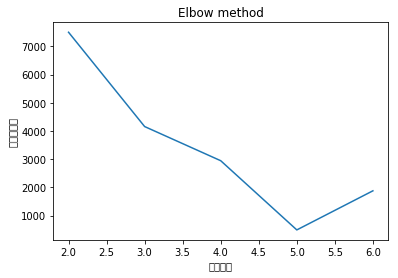

In [286]:
%matplotlib inline

M = 1000
dataset = np.matrix(derived_features)[:M,]
cost = []
for k in range(2, 7):
    result = KmeansAlgo(dataset, k)
    cost.append(result['cost'])

plt.plot(range(2, 7), cost[:5])
plt.xlabel("簇的个数")
plt.ylabel("簇的损失量")
plt.title("Elbow method")
plt.show()

In [323]:
result = KmeansAlgo(dataset, 3)
datasetLabel = np.column_stack((dataset, result['group']))

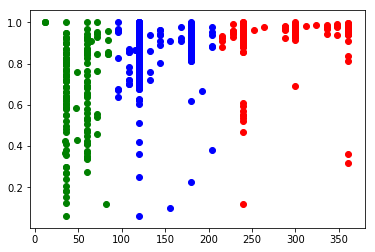

In [324]:
cols = ['g','b','r']
for l in range(3):
    groupIndex = [i for i in range(M) if result['group'][i]==l]
    x = dataset[groupIndex,2]
    y = dataset[groupIndex, 10]
    p =plt.scatter(list(x), list(y), color = cols[l])

# 分层聚类

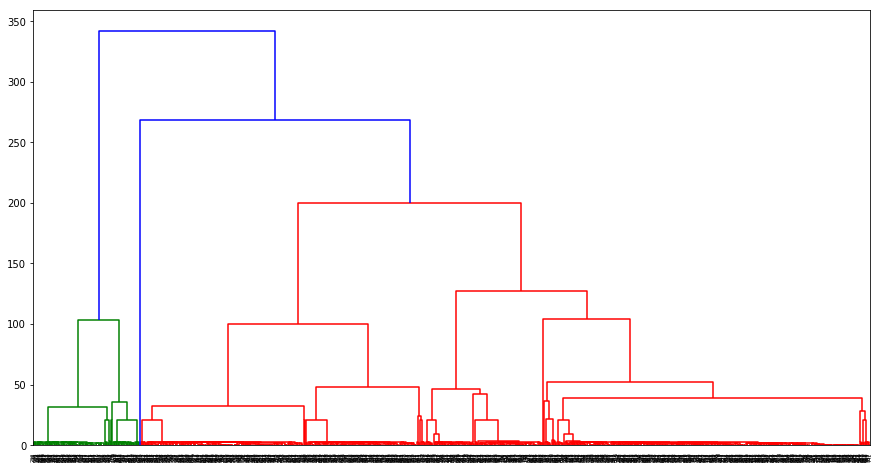

In [325]:
plt.figure(figsize=(15,8))

disMat = sch.distance.pdist(dataset, 'euclidean')
Z = sch.linkage(disMat, method='average')
P = sch.dendrogram(Z)
cluster = sch.fcluster(Z, t=1, criterion='inconsistent')

# 集成聚类

In [326]:
C = 100
labelLoop = []
k = 3
for c in range(C):
    result = KMeans(n_clusters=k, random_state=0).fit(dataset)
    labelLoop.append(result.labels_)

countOfLabel = {i:{p:0 for p in range(k)} for i in range(M)}
predictedLable = {}
for i in range(M):
    for c in range(C):
        countOfLabel[i][labelLoop[c][i]] += 1
    count = countOfLabel[i]
    predictedLable[i] = sorted(count, key=lambda x: count[x])[-1]
    
predictedLable[0]

1